In [37]:
#% matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from astropy import units as u
from astropy.coordinates import SkyCoord
import healpy as hp
from astropy.io.votable import parse_single_table
import matplotlib.cm as cm
from scipy.stats import median_abs_deviation as mad

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

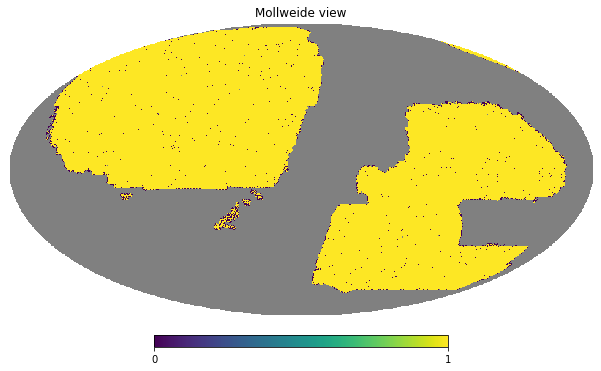

In [55]:
# Read both data sets and the full coverage mask

wholesouthdata = pd.read_csv('../../bricks_data/uncleaned_systematics_south.csv')

northdata = pd.read_csv('../../bricks_data/uncleaned_systematics_north.csv')

fullmask = hp.read_map("../../bricks_data/masks/mask_512.fits")
fullmask = fullmask[hp.ring2nest(512, np.arange(hp.nside2npix(512)))]
hp.mollview(fullmask, rot=110)



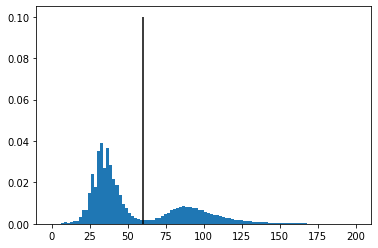

In [56]:
# create arrays holding coordinates of healpix pixels
# both longitude-latitude and galactic coordinates, in order to make further cuts.
lon, lat = hp.pix2ang(512, np.arange(hp.nside2npix(512)), lonlat=True, nest=False)
theta, phi = hp.pix2ang(512, np.arange(hp.nside2npix(512)), lonlat=False, nest=False)
rot = hp.Rotator(coord=['E', 'G'])
l, b = rot(theta, phi)

# for the south we can split DES & DECALS based on number of exposures

plt.hist(wholesouthdata['exposures'], range=[0, 200], bins=100, density=True)
plt.vlines(60, 0, .1, color='k')


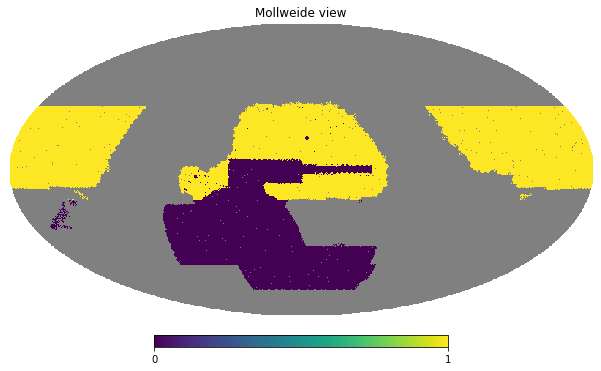

In [57]:
# main cuts for south
southipixmask = np.logical_or(
    wholesouthdata['exposures'] < 60,
    l[wholesouthdata['pixel_id']] < np.pi / 2
)
southipixmask &= lat[wholesouthdata['pixel_id']] > -15

# apply coverage mask, just in case.
southipixmask &= fullmask[wholesouthdata['pixel_id']]

hpmap = np.zeros(hp.nside2npix(512)) + hp.UNSEEN
hpmap[wholesouthdata['pixel_id'][southipixmask]] = 1
hpmap[wholesouthdata['pixel_id'][~southipixmask]] = 0

hp.mollview(hpmap)

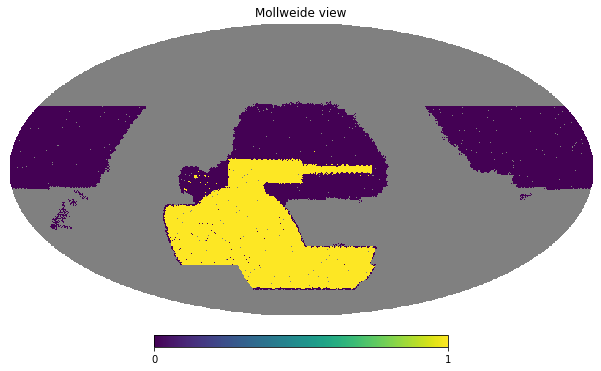

In [58]:
# main cuts for DES
desipixmask = wholesouthdata['exposures'] > 60
desipixmask &= lat[wholesouthdata['pixel_id']] < 10
desipixmask &= l[wholesouthdata['pixel_id']] > np.pi / 2

# apply coverage mask, just in case.
hpmap = np.zeros(hp.nside2npix(512)) + hp.UNSEEN
hpmap[wholesouthdata['pixel_id'][desipixmask]] = 1
hpmap[wholesouthdata['pixel_id'][~desipixmask]] = 0

hp.mollview(hpmap)

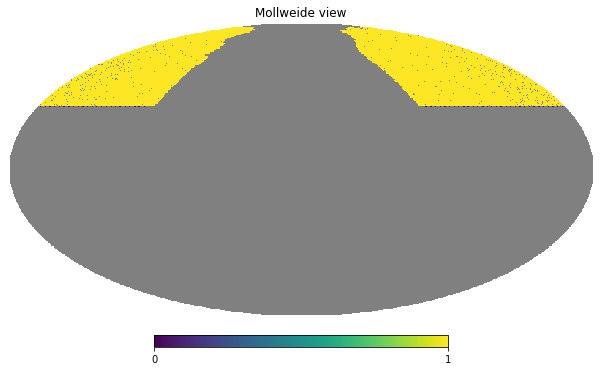

In [59]:
# north mask

northipixmask = fullmask[northdata['pixel_id']] > 0
# remove pixels already in south!
northipixmask &= ~np.in1d(northdata['pixel_id'], wholesouthdata['pixel_id'])

hpmap = np.zeros(hp.nside2npix(512)) + hp.UNSEEN
hpmap[northdata['pixel_id'][northipixmask]] = 1
hpmap[northdata['pixel_id'][~northipixmask]] = 0

hp.mollview(hpmap)

In [60]:
# Now create arrays holding the three data sets

desdata = wholesouthdata[desipixmask]
southdata = wholesouthdata[southipixmask]
northdata = northdata[northipixmask]


In [61]:
# Select one of them! for running the rest of the code below
# (a hacky way to make a choice...)

area = 'des'

if area == 'north':
    data = northdata
elif area == 'south':
    data = southdata
else:
    data = desdata

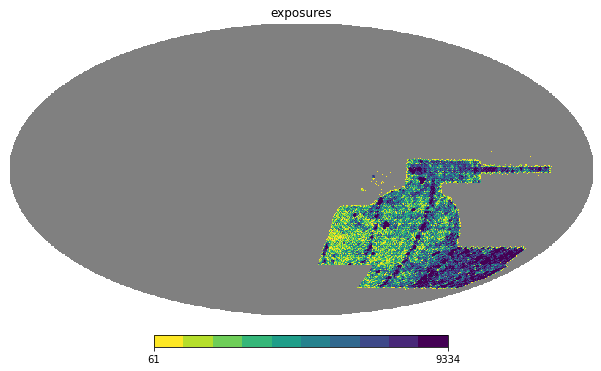

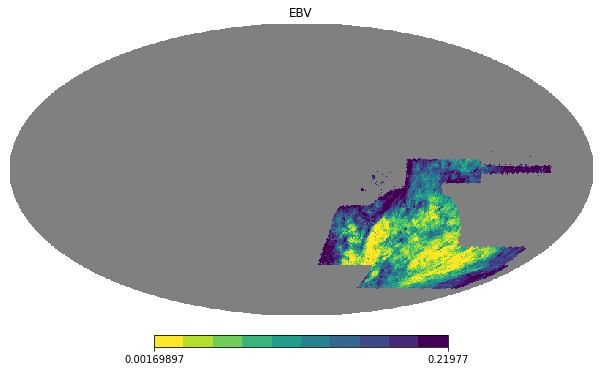

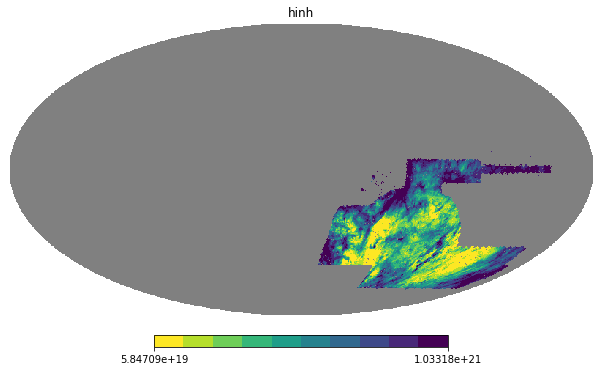

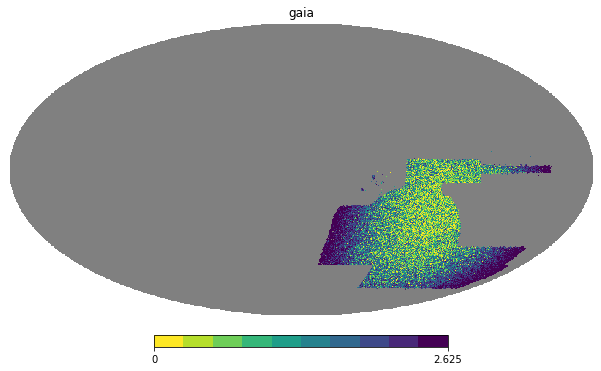

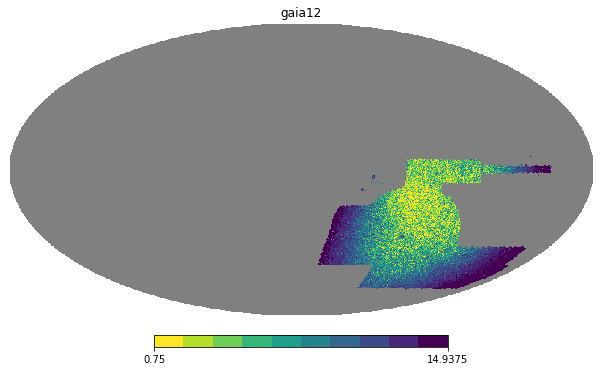

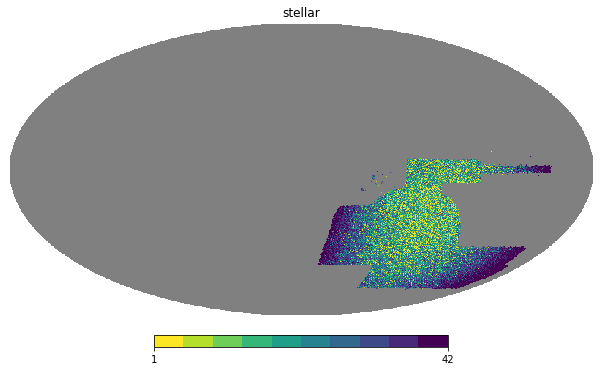

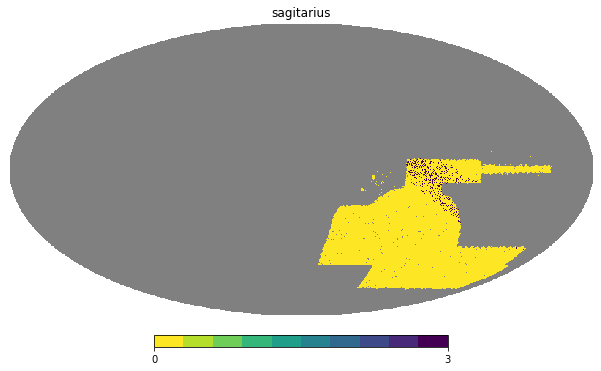

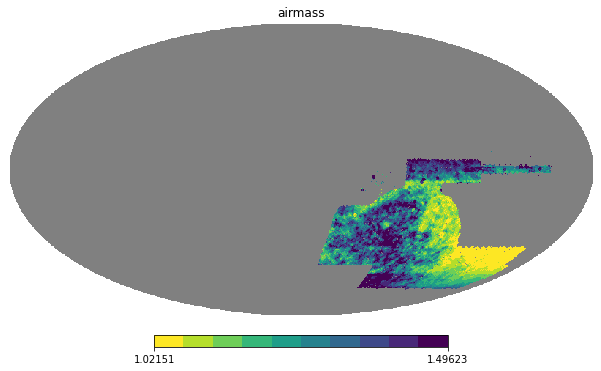

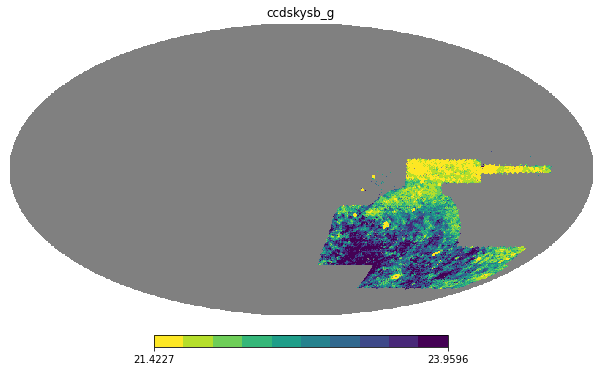

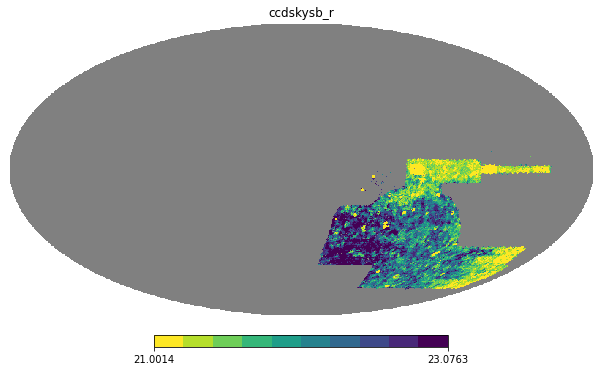

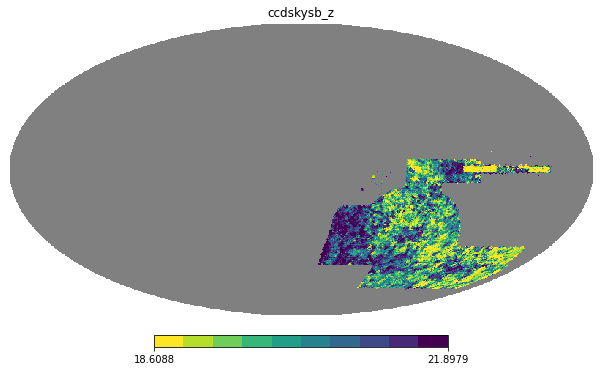

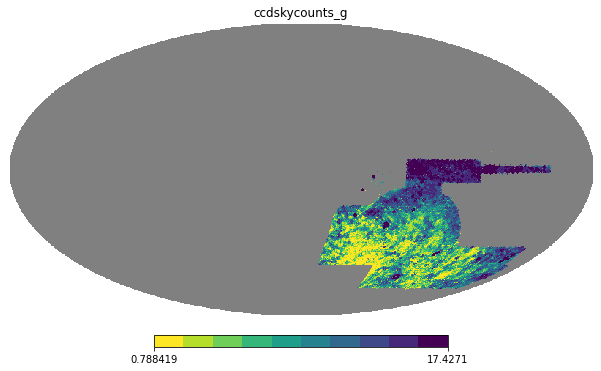

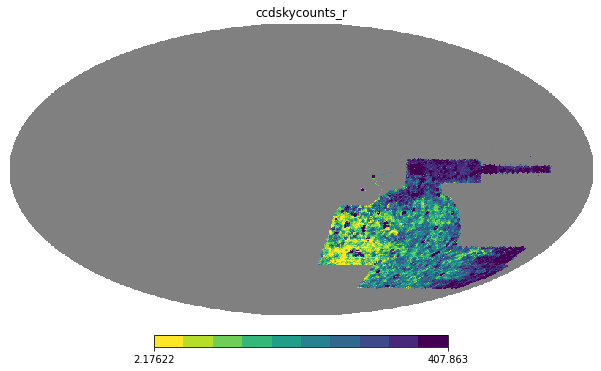

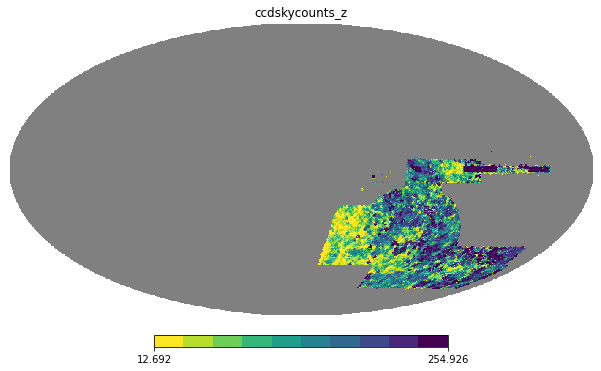

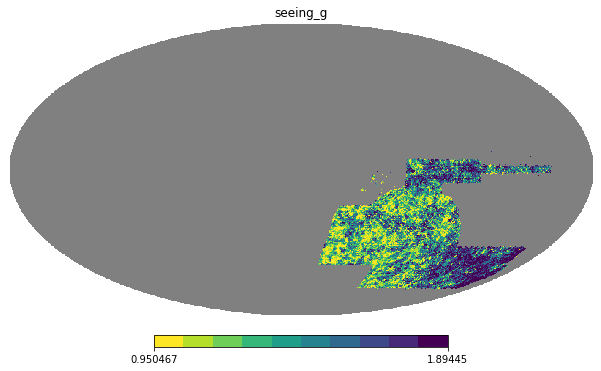

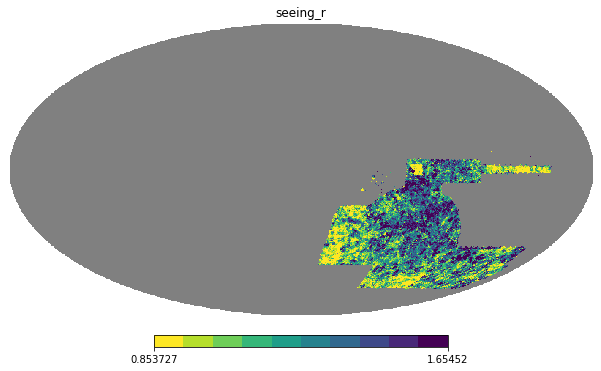

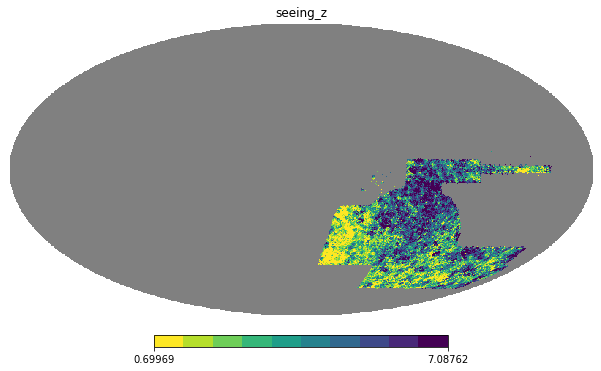

In [62]:
# simply plot all maps

names = [
    'exposures',
    'EBV',
    'hinh', 'gaia', 'gaia12', 'stellar', 'sagitarius', 'airmass',
    'ccdskysb_g', 'ccdskysb_r', 'ccdskysb_z',
    'ccdskycounts_g', 'ccdskycounts_r', 'ccdskycounts_z',
    'seeing_g', 'seeing_r', 'seeing_z'
]

for i, nm in enumerate(names):
    hpmap = np.zeros(hp.nside2npix(512)) + hp.UNSEEN
    hpmap[data['pixel_id']] = data[nm]
    hp.mollview(hpmap, hold=False, cmap=cm.get_cmap('viridis_r', 10), norm='hist', rot=110, title=nm)

In [63]:
# which ones to make mask cuts on?

names = [
    #'exposures',
    'EBV',
    'hinh', 'gaia', 'gaia12', 'stellar', 'airmass',
    'ccdskysb_g', 'ccdskysb_r', 'ccdskysb_z',
    'ccdskycounts_g', 'ccdskycounts_r', 'ccdskycounts_z',
    'seeing_g', 'seeing_r', 'seeing_z']

In [64]:
# number of standard deviations away from mean
x = 10

Systematic EBV 337
Systematic hinh 11
Systematic gaia 2
Systematic gaia12 211
Systematic stellar 7564
Systematic airmass 0
Systematic ccdskysb_g 492
Systematic ccdskysb_r 85
Systematic ccdskysb_z 44
Systematic ccdskycounts_g 7256
Systematic ccdskycounts_r 8106
Systematic ccdskycounts_z 1117
Systematic seeing_g 0
Systematic seeing_r 0
Systematic seeing_z 54


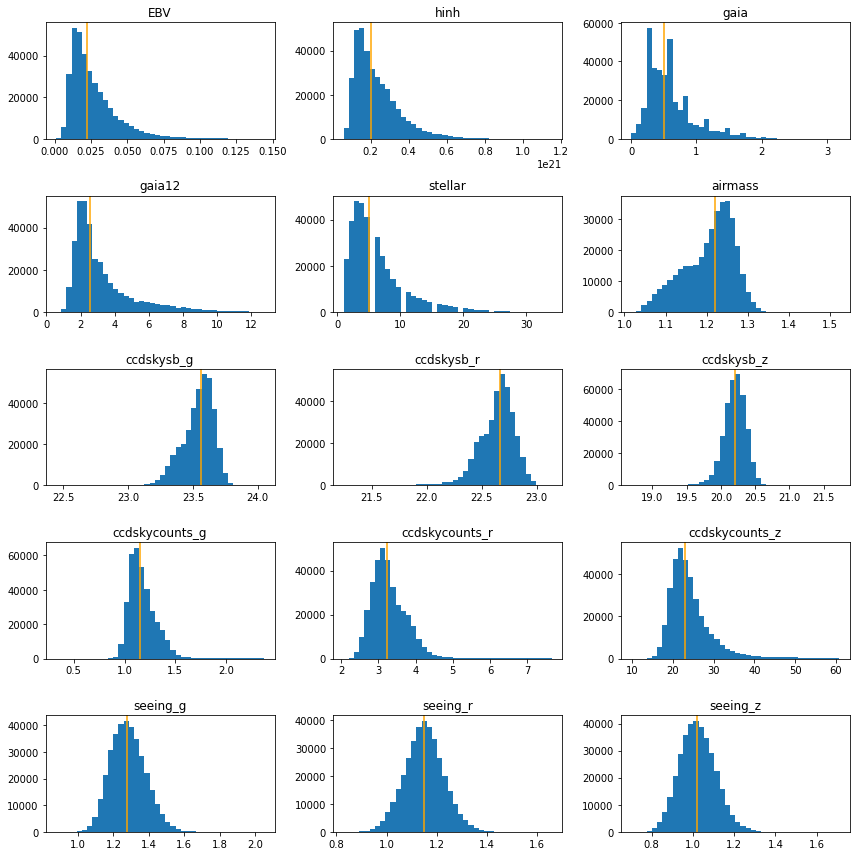

In [65]:
# now plot histograms of the pixel values in each map AFTER the median+-stdev cut.
ipix = data['pixel_id']
fig, axs = plt.subplots(5, 3, figsize=(12, 12))
axs = axs.ravel()
hpmap = np.zeros(hp.nside2npix(512)) + hp.UNSEEN

for i, nm in enumerate(names):
    themin, themax = np.min(data[nm]), np.max(data[nm])
    ind = np.isfinite(data[nm])
    themean, thestd = np.median(data[nm][ind]), mad(data[nm][ind], scale='normal')
    themin2 = themean - x * thestd
    themax2 = themean + x * thestd
    ind &= data[nm] <= themax2
    ind &= data[nm] >= themin2

    print('Systematic', nm, np.sum(~ind))
    hpmap[ipix[~ind]] = 1
    hpmap[ipix[hpmap[ipix] == hp.UNSEEN]] = 0

    axs[i].hist(data[nm][ind], log=False, bins=40)
    axs[i].axvline(themean, c='orange')
    axs[i].set_title(nm)
fig.tight_layout()

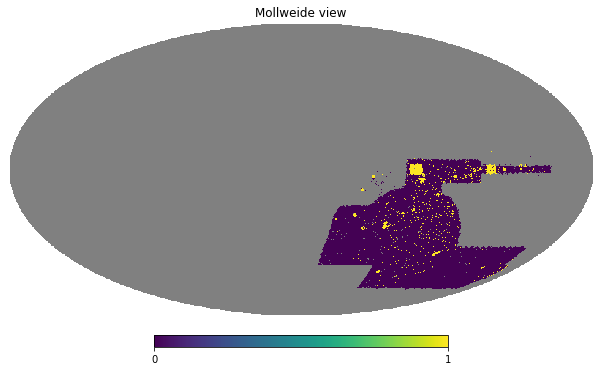

In [66]:


# plot the resulting total mask.
hp.mollview(hpmap, rot=110, cmap='viridis')

In [67]:
unique = np.arange((hp.nside2npix(512)))

id_density = np.stack((unique, hpmap), axis=1)

df = pd.DataFrame(id_density, columns=['pixel_id', 'hpmap'])
df.pixel_id = df.pixel_id.astype(int)

print(f"Total Pixels: {len(df)}")
df.head()
print(f"Total Len of Raw Data: {len(data)}")

print(f"Pixels Cut Outlier Removal: {(hpmap == 1.0).sum()}")

Total Pixels: 3145728
Total Len of Raw Data: 356855
Pixels Cut Outlier Removal: 18329


In [68]:
print(len(df), len(data))
df_final = pd.merge(data, df, how='inner', on='pixel_id')
#df.drop(columns='coverage')
print(df_final.hpmap.unique())
df_final = df_final[df_final.hpmap == 0.0]
print(df_final.hpmap.unique())



3145728 356855
[1. 0.]
[0.]


In [69]:
df_final.drop(columns=['exptime_g', 'exptime_r', 'exptime_z','meansky_g', 'meansky_r', 'meansky_z', 'hpmap'], inplace=True)
df_final.columns

Index(['pixel_id', 'lrg', 'elg', 'qso', 'glbg', 'rlbg', 'exposures', 'hinh',
       'gaia', 'gaia12', 'sagitarius', 'stellar', 'EBV', 'airmass',
       'ccdskysb_g', 'ccdskysb_r', 'ccdskysb_z', 'ccdskycounts_g',
       'ccdskycounts_r', 'ccdskycounts_z', 'seeing_g', 'seeing_r', 'seeing_z'],
      dtype='object')

In [70]:
cols = ['exposures', 'hinh',
        'gaia', 'gaia12', 'sagitarius', 'stellar', 'EBV',
        'airmass', 'ccdskysb_g', 'ccdskysb_r', 'ccdskysb_z',
        'ccdskycounts_g', 'ccdskycounts_r', 'ccdskycounts_z', 'seeing_g', 'seeing_r',
        'seeing_z']

In [71]:
print("Name & Median & Std & Min & Max & 15.9% & 84.1%")

for col in cols:

    print(col, '&',
          round(df_final[col].median(),3),'&',
          round(df_final[col].std(),3), '&',
          round(df_final[col].min(), 3),'&',
          round(df_final[col].max(),3), '&',
          round(np.quantile(a=df_final[col], q=0.159),3), '&',
          round(np.quantile(a=df_final[col], q=0.841),3))



    #print("Median:" , df_final[col].median())
    #print("SD:" , df_final[col].sd())


Name & Median & Std & Min & Max & 15.9% & 84.1%
exposures & 92.0 & 123.514 & 61 & 9986 & 78.0 & 114.0
hinh & 1.9679600953265016e+20 & 1.1715757004126796e+20 & 5.728652173392006e+19 & 9.105545204228812e+20 & 1.2544219111733142e+20 & 3.3389280554139766e+20
gaia & 0.5 & 0.369 & 0.0 & 3.062 & 0.312 & 0.938
gaia12 & 2.625 & 1.879 & 0.562 & 12.75 & 1.875 & 4.875
sagitarius & 0.0 & 0.178 & 0.0 & 4.0 & 0.0 & 0.0
stellar & 5.0 & 4.664 & 1.0 & 34.0 & 2.0 & 10.0
EBV & 0.022 & 0.017 & 0.001 & 0.144 & 0.013 & 0.041
airmass & 1.218 & 0.061 & 1.016 & 1.488 & 1.134 & 1.264
ccdskysb_g & 23.564 & 0.113 & 22.782 & 24.049 & 23.427 & 23.655
ccdskysb_r & 22.67 & 0.14 & 21.915 & 23.137 & 22.499 & 22.791
ccdskysb_z & 20.211 & 0.157 & 19.277 & 21.726 & 20.055 & 20.359
ccdskycounts_g & 1.15 & 0.14 & 0.787 & 2.375 & 1.055 & 1.307
ccdskycounts_r & 3.203 & 0.522 & 2.063 & 7.654 & 2.845 & 3.762
ccdskycounts_z & 23.066 & 5.394 & 9.788 & 60.767 & 19.973 & 28.302
seeing_g & 1.277 & 0.098 & 0.876 & 2.051 & 1.184 & 1.38

In [47]:
scaler = MinMaxScaler()

In [48]:

print(df_final.columns)

Index(['pixel_id', 'lrg', 'elg', 'qso', 'glbg', 'rlbg', 'exposures', 'hinh',
       'gaia', 'gaia12', 'sagitarius', 'stellar', 'EBV', 'airmass',
       'ccdskysb_g', 'ccdskysb_r', 'ccdskysb_z', 'ccdskycounts_g',
       'ccdskycounts_r', 'ccdskycounts_z', 'seeing_g', 'seeing_r', 'seeing_z'],
      dtype='object')


In [49]:
df_final[cols] = scaler.fit_transform(df_final[cols])

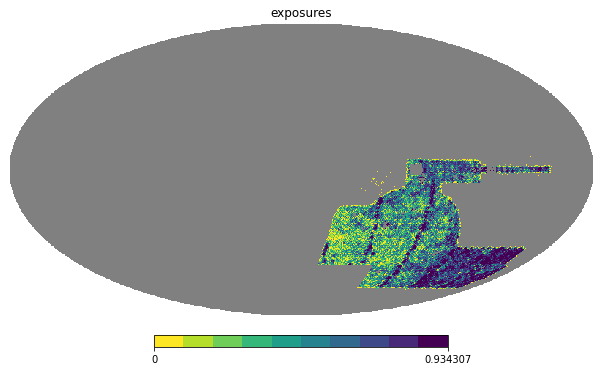

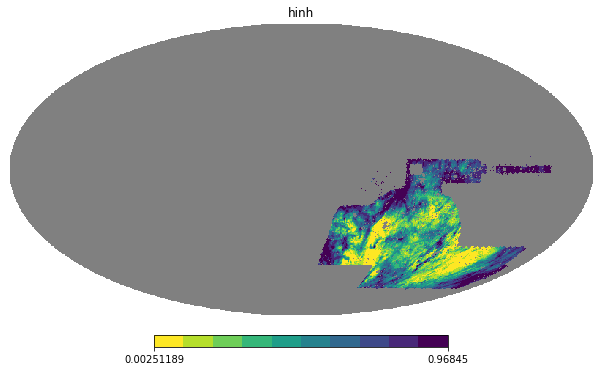

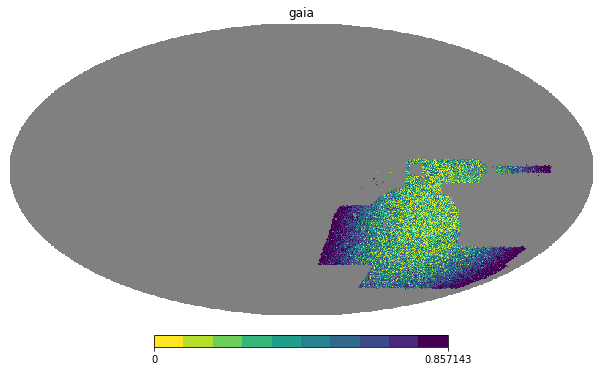

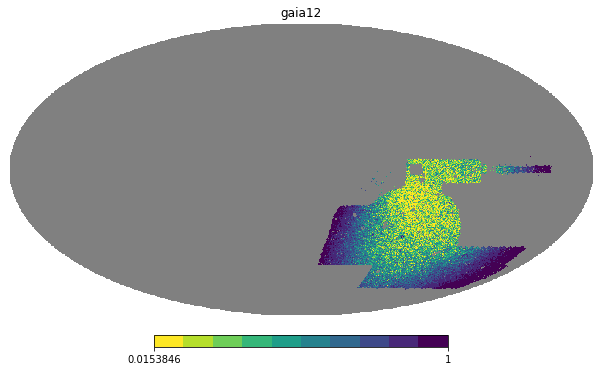

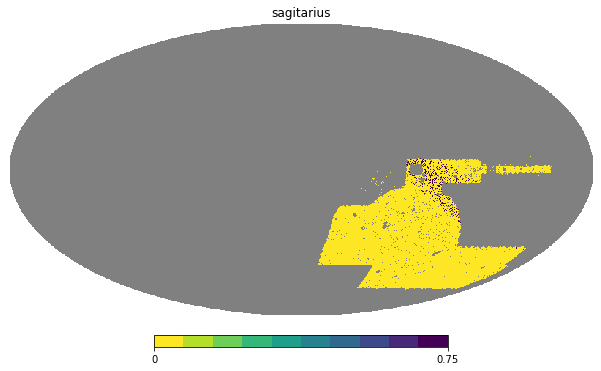

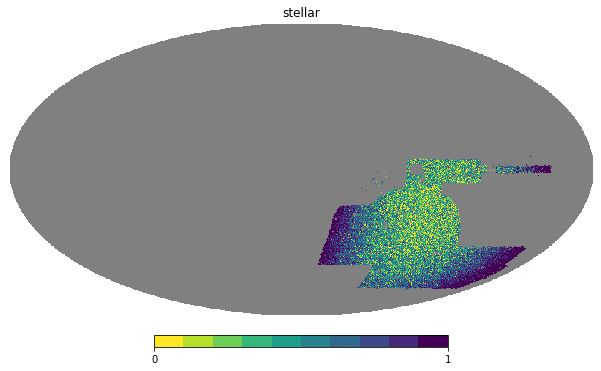

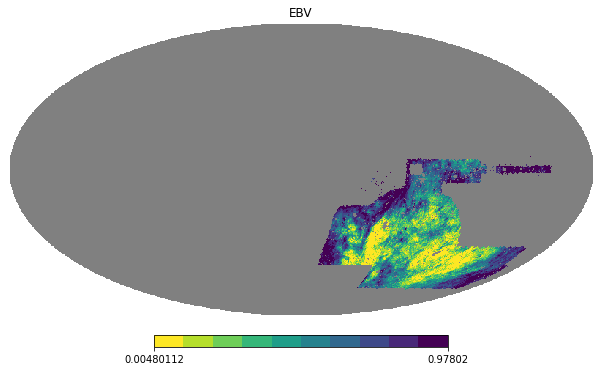

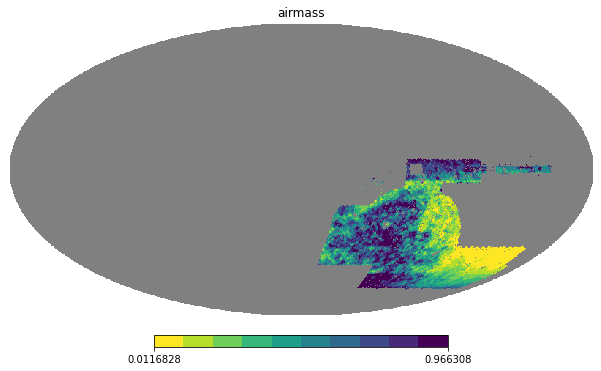

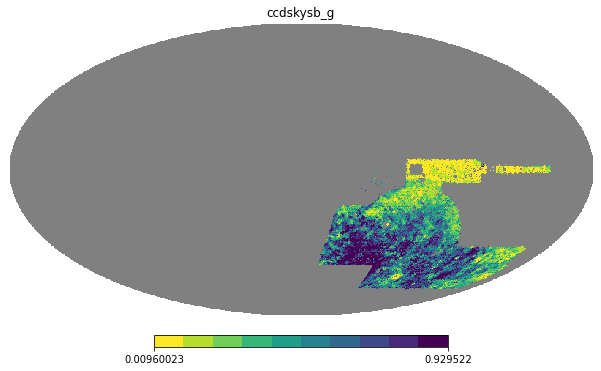

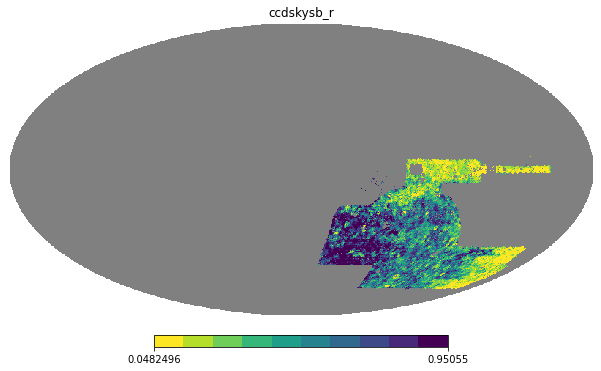

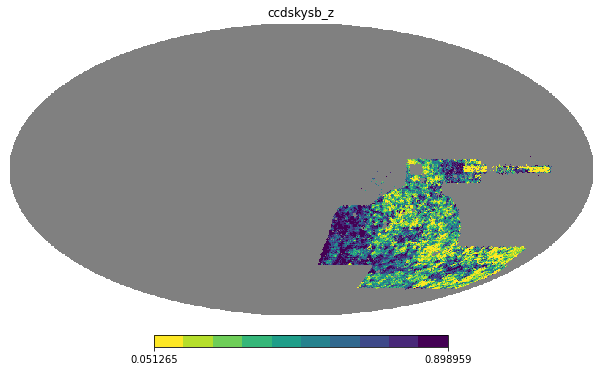

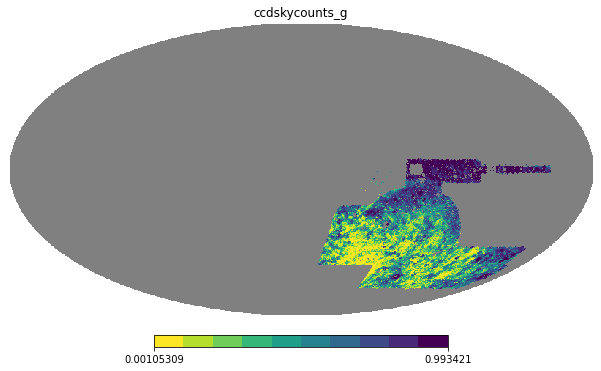

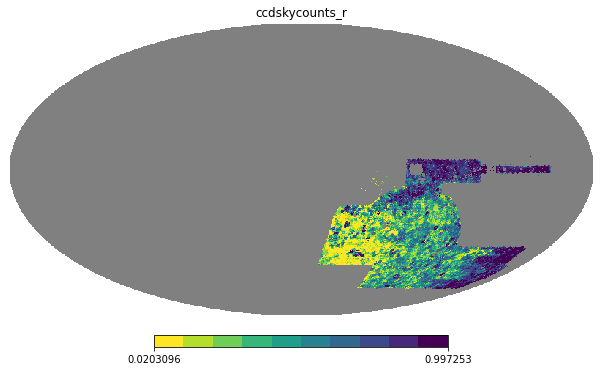

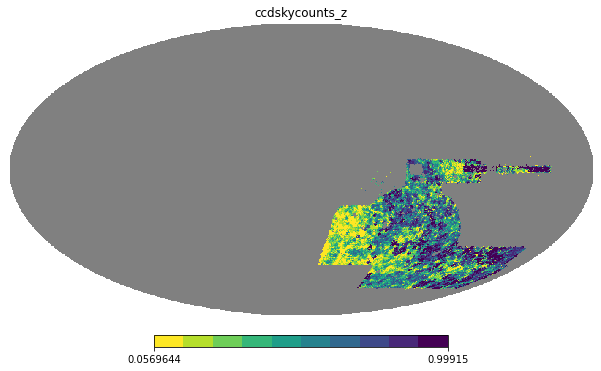

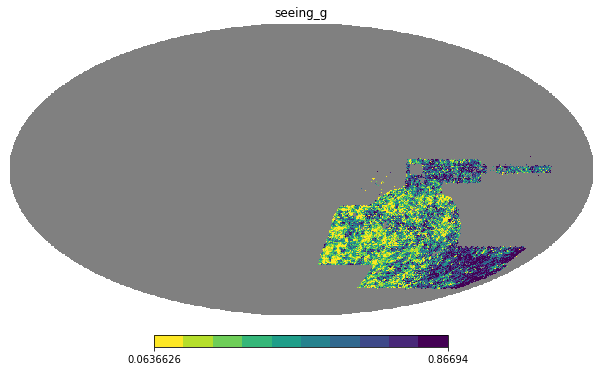

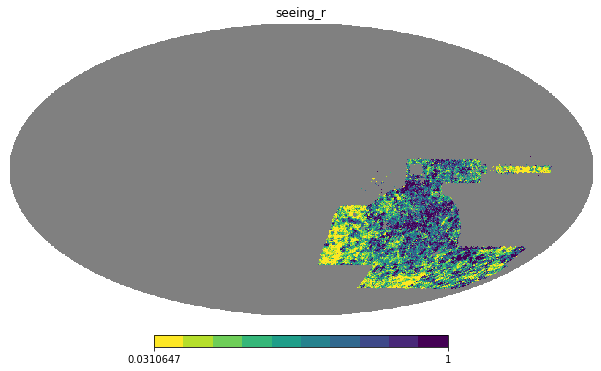

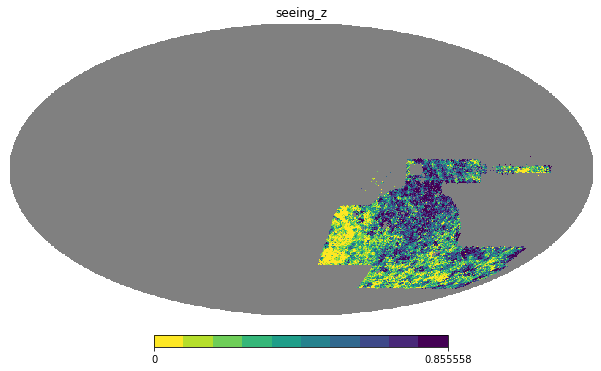

In [50]:
for i, nm in enumerate(cols):
    hpmap = np.zeros(hp.nside2npix(512)) + hp.UNSEEN
    hpmap[df_final['pixel_id']] = df_final[nm]
    hp.mollview(hpmap, hold=False, cmap=cm.get_cmap('viridis_r', 10), norm='hist', rot=110, title=nm)

In [51]:

df_train, df_test = train_test_split(df_final, test_size=0.2, random_state=666, shuffle=True)
print(len(df_train))
print(len(df_test))


270820
67706


In [52]:
df_train.to_csv(f'../../bricks_data/{area}_512.csv', index=False)
df_test.to_csv(f'../../bricks_data/{area}_test_512.csv', index=False)

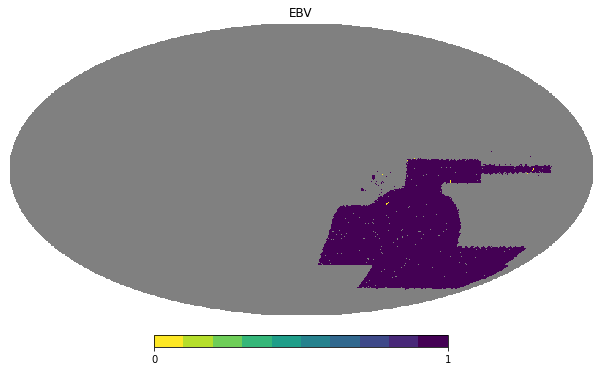

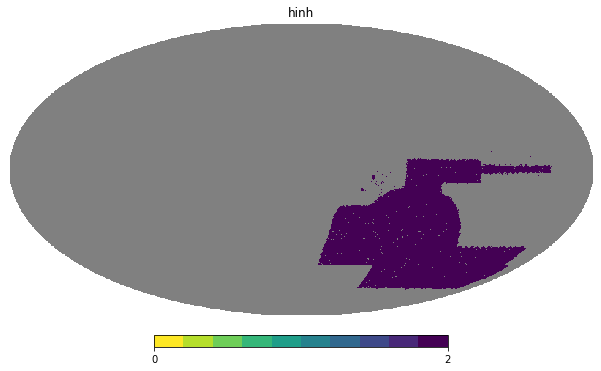

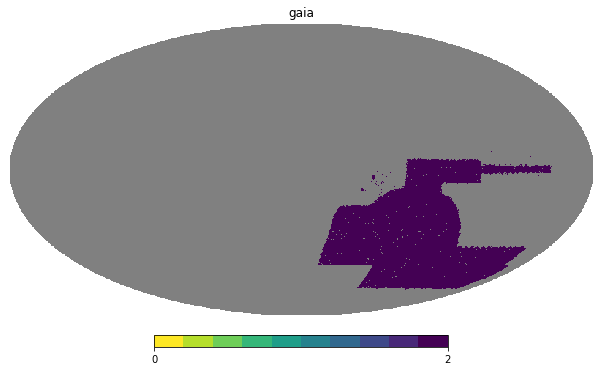

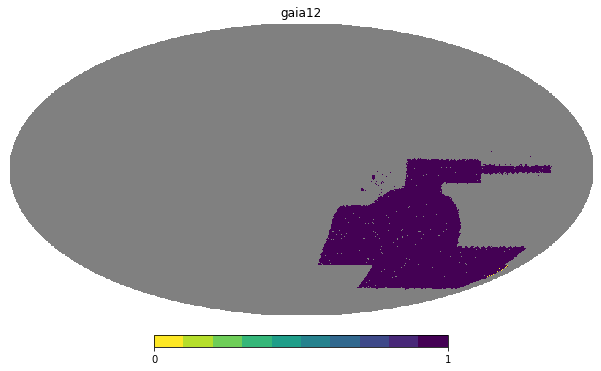

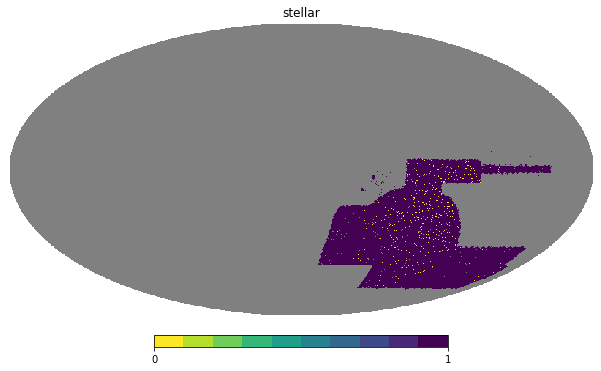

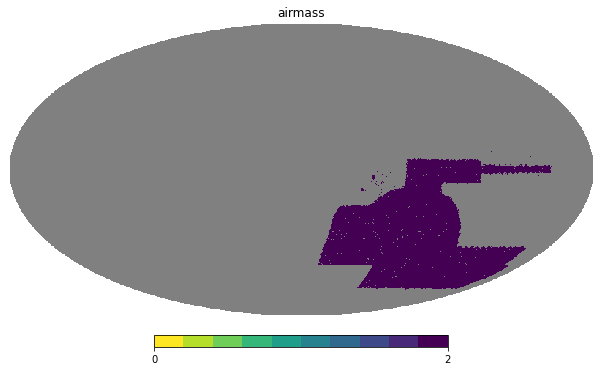

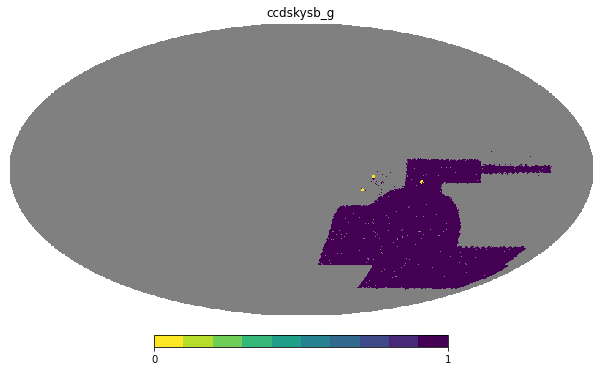

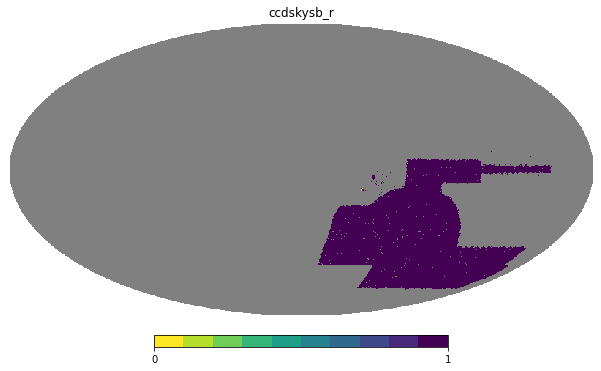

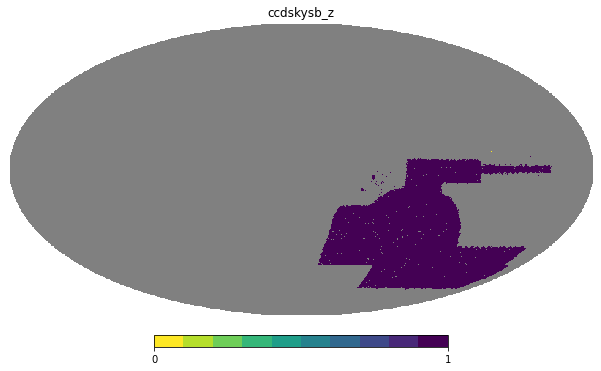

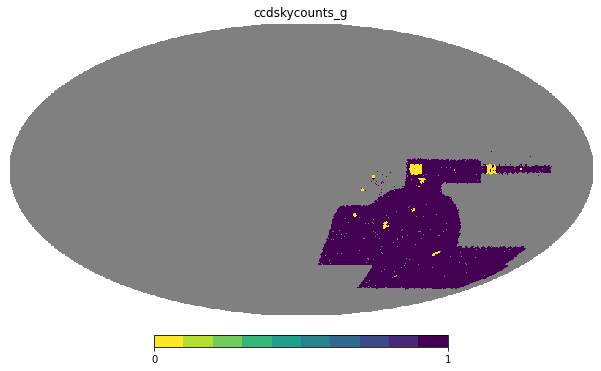

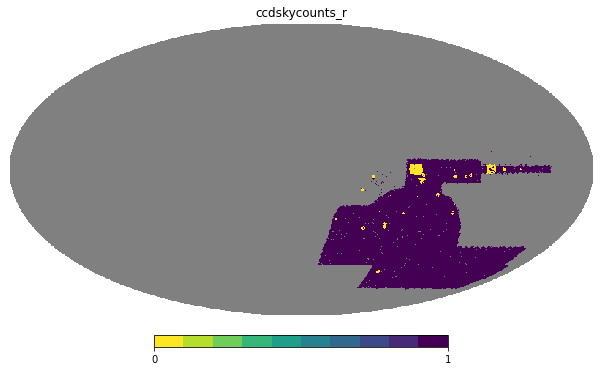

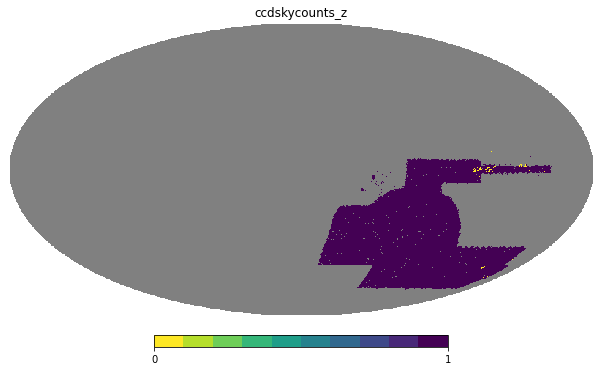

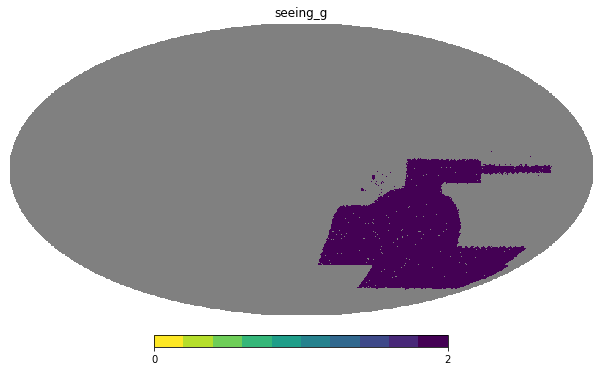

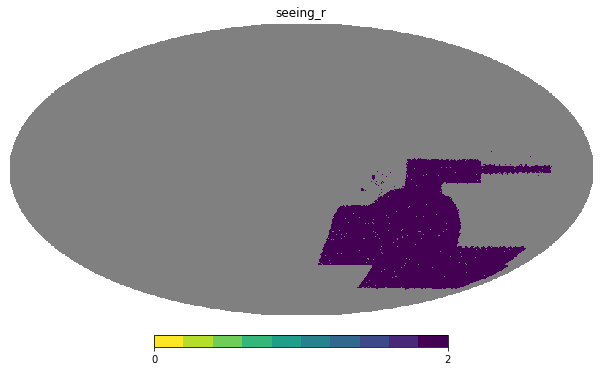

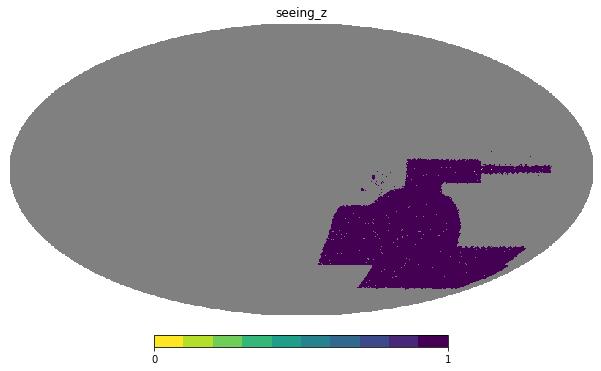

In [131]:
# repeat the loop over systematics but now show what pixels are being cut for each

hpmap = np.zeros(hp.nside2npix(512)) + hp.UNSEEN

for i, nm in enumerate(names):
    themin, themax = np.min(data[nm]), np.max(data[nm])
    ind = np.isfinite(data[nm])
    themean, thestd = np.median(data[nm][ind]), mad(data[nm][ind], scale='normal')
    themin2 = themean - x * thestd
    themax2 = themean + x * thestd
    ind &= data[nm] <= themax2
    ind &= data[nm] >= themin2
    if np.sum(ind) > 0:
        hpmap = np.zeros(hp.nside2npix(512)) + hp.UNSEEN
        hpmap[ipix[ind]] = 1
        hpmap[ipix[hpmap[ipix] == hp.UNSEEN]] = 0
        hp.mollview(hpmap, hold=False, cmap=cm.get_cmap('viridis_r', 10), norm='hist', rot=110, title=nm)